## NON-LLM Based Workflow

### Creating the most simple workflow

In [5]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [3]:
#defining state

class BMIState(TypedDict):

    weight_kg: float
    height_m: float
    bmi: float

In [4]:
#creating node function

def calculate_bmi(state: BMIState) -> BMIState:
    
    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight/(height**2)

    state['bmi'] = round(bmi, 2)

    return state

In [ ]:
#defining the graph
graph = StateGraph(BMIState)

#add nodes to the graph
graph.add_node("calculate_bmi", calculate_bmi)

#add edges to the graph
graph.add_edge(START, "calculate_bmi")
graph.add_edge("calculate_bmi", END)

#compile the graph
workflow = graph.compile()

In [7]:
#execute the graph

workflow.invoke({'weight_kg': 80, 'height_m': 1.73})

{'weight_kg': 80, 'height_m': 1.73, 'bmi': 26.73}

In [8]:
#another way to execcute the graph in a structured way

initial_state = ({'weight_kg': 80, 'height_m': 1.73})

final_state = workflow.invoke(initial_state)

In [9]:
print(final_state)

{'weight_kg': 80, 'height_m': 1.73, 'bmi': 26.73}


In [10]:
final_state

{'weight_kg': 80, 'height_m': 1.73, 'bmi': 26.73}

### Visually representing the graph for above workflow

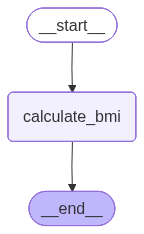

In [12]:
from IPython.display import Image   #this whole code only works in jupyter notrebook and not in .py file
Image(workflow.get_graph().draw_mermaid_png())

### Now making changes to the above and making it little more heavy 

In [13]:
#defining state

class BMIState(TypedDict):

    weight_kg: float
    height_m: float
    bmi: float
    category: str

In [14]:
#creating node function

def calculate_bmi(state: BMIState) -> BMIState:
    
    weight = state['weight_kg']
    height = state['height_m']

    bmi = weight/(height**2)

    state['bmi'] = round(bmi, 2)

    return state

def label_bmi(state: BMIState) -> BMIState:

    bmi = state['bmi']

    if bmi < 18.5:
        category = 'Underweight'
    elif 18.5 <= bmi < 24.9:
        category = 'Normal weight'
    elif 25 <= bmi < 29.9:
        category = 'Overweight'
    else:
        category = 'Obesity'

    state['category'] = category

    return state

    

In [15]:
#defining the graph
graph = StateGraph(BMIState)

#add nodes to the graph
graph.add_node("calculate_bmi", calculate_bmi)
graph.add_node("label_bmi", label_bmi)

#add edges to the graph
graph.add_edge(START, "calculate_bmi")
graph.add_edge("calculate_bmi", "label_bmi")
graph.add_edge("label_bmi", END)

#compile the graph
workflow = graph.compile()

In [17]:
initial_state = ({'weight_kg': 80, 'height_m': 1.73})
final_state = workflow.invoke(initial_state)
final_state

{'weight_kg': 80, 'height_m': 1.73, 'bmi': 26.73, 'category': 'Overweight'}

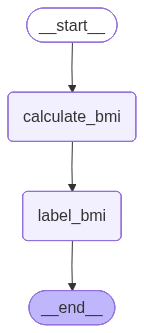

In [16]:
from IPython.display import Image   #this whole code only works in jupyter notrebook and not in .py file
Image(workflow.get_graph().draw_mermaid_png())

## LLM-Based Workflow

### QA Simple Workflow using Langchain + Langgraph

In [7]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from typing import TypedDict
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [31]:
import os
GROK_API_KEY = os.getenv("GROK_API_KEY")


In [35]:
model = ChatGroq(api_key=GROK_API_KEY, model="openai/gpt-oss-120b")

In [5]:
# create a state

class LLMState(TypedDict):

    question: str
    answer: str

In [20]:
def llm_qa( state: LLMState) -> LLMState:

    #extract question from state
    question = state['question']

    #form a prompt
    prompt = f"answer the following question {question}"

    #ask the question to the llm
    answer = model.invoke(prompt).content

    #update the answer in the state
    state['answer'] = answer

    return state

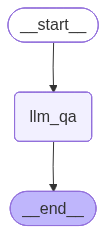

In [16]:
# create our graph

graph =  StateGraph(LLMState)

#add nodes
graph.add_node("llm_qa", llm_qa)

#add edgees
graph.add_edge(START, "llm_qa")
graph.add_edge("llm_qa", END)

#compile
graph.compile()

In [22]:
workflow = graph.compile()

In [36]:
#execute the graph

initial_state = {'question': "what was the birth year of Kim Bum Soo?"}
final_state = workflow.invoke(initial_state)

final_state

{'question': 'what was the birth year of Kim Bum Soo?',
 'answer': 'Kim\u202fBum‑Soo was born in **1979** (January\u202f26,\u202f1979).'}

In [37]:
final_state['question']

'what was the birth year of Kim Bum Soo?'

In [38]:
final_state['answer']

'Kim\u202fBum‑Soo was born in **1979** (January\u202f26,\u202f1979).'

In [40]:
# we could also write like this

model.invoke("what was the birth year of Kim Bum Soo?").content

'Kim\u202fBum‑Soo was born in **1979** (January\u202f26,\u202f1979).'

## PROMPT CHAINING

start -> generate_outline(llm) -> generate_blog(llm) -> end

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from typing import TypedDict
from dotenv import load_dotenv

In [2]:
load_dotenv()

True

In [3]:
import os
GROK_API_KEY = os.getenv("GROK_API_KEY")

In [4]:
model = ChatGroq(api_key = GROK_API_KEY , model="openai/gpt-oss-120b")

In [5]:
# state graph

class BlogState(TypedDict):

    title: str
    outline: str
    content: str

In [6]:
#create functions for nodes

def create_outline(state: BlogState) -> BlogState:
    
    #fetch title from state
    title = state['title']
    
    #form prompt
    prompt = f"create a detailed outline for a blog post with the title: {title}"
    
    #giving prompt to get outline
    outline = model.invoke(prompt).content
    
    #update outline in state
    state['outline'] = outline

    return state


def create_content(state: BlogState) -> BlogState:

    #fetch outline from state
    outline = state['outline']
    
    #form prompt
    prompt = f"create a detailed blog post based on the following outline: {outline}"
    
    #giving prompt to get content
    content = model.invoke(prompt).content
    
    #update content in state
    state['content'] = content

    return state

In [7]:
#create graph
graph = StateGraph(BlogState)

#add nodes
graph.add_node("create_outline", create_outline)
graph.add_node("create_content", create_content)

#add edges
graph.add_edge(START, "create_outline")
graph.add_edge("create_outline", "create_content")
graph.add_edge("create_content", END)

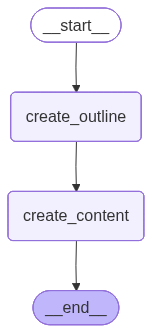

In [8]:
workflow = graph.compile()
workflow

In [9]:
initial_state = {'title': "The future of real hands art"}
final_state = workflow.invoke(initial_state)

In [10]:
final_state

{'title': 'The future of real hands art',
 'outline': '**Blog Post Outline – “The Future of Real Hands Art”**\n\n---\n\n### 1. Introduction  \n- **Hook:** A vivid anecdote or image of a hand‑drawn masterpiece that captures the viewer’s imagination.  \n- **Definition:** What “real hands art” means (art created by human hands, as opposed to AI‑generated or purely digital output).  \n- **Why It Matters:** Briefly discuss the cultural, emotional, and market relevance of hand‑crafted art in an increasingly automated world.  \n- **Thesis Statement:** Preview the key forces shaping the future of real‑hand art—technology, sustainability, education, market dynamics, and cultural shifts.\n\n---\n\n### 2. Historical Context: From Cave Paintings to Contemporary Handcraft  \n- **Early Milestones:** Paleolithic cave drawings, illuminated manuscripts, Renaissance drawing techniques.  \n- **The Rise of Print & Photography:** How reproducibility challenged the primacy of the hand.  \n- **Modern Movemen

In [13]:
print(final_state['outline'])

**Blog Post Outline – “The Future of Real Hands Art”**

---

### 1. Introduction  
- **Hook:** A vivid anecdote or image of a hand‑drawn masterpiece that captures the viewer’s imagination.  
- **Definition:** What “real hands art” means (art created by human hands, as opposed to AI‑generated or purely digital output).  
- **Why It Matters:** Briefly discuss the cultural, emotional, and market relevance of hand‑crafted art in an increasingly automated world.  
- **Thesis Statement:** Preview the key forces shaping the future of real‑hand art—technology, sustainability, education, market dynamics, and cultural shifts.

---

### 2. Historical Context: From Cave Paintings to Contemporary Handcraft  
- **Early Milestones:** Paleolithic cave drawings, illuminated manuscripts, Renaissance drawing techniques.  
- **The Rise of Print & Photography:** How reproducibility challenged the primacy of the hand.  
- **Modern Movements:** Abstract Expressionism, Street Art, and the resurgence of hand‑b

In [14]:
print(final_state['content'])

**The Future of Real Hands Art**  
*How technology, sustainability, education, market forces, and cultural shifts are reshaping the work that still comes from a human fingertip.*

---

## 1. Introduction  

**Hook – A Hand‑Drawn Moment Frozen in Time**  
Imagine stepping into a dimly lit gallery and being drawn to a massive charcoal sketch that seems to pulse with life. The lines are raw, the shadows deep, and you can almost feel the pressure of the artist’s hand as the charcoal meets paper. A single swipe of the wrist reveals a face that is both familiar and uncanny—an image that could not have been generated by an algorithm because every imperfection is a fingerprint of intention.

**What Is “Real Hands Art”?**  
In today’s lexicon, “real hands art” refers to any visual work that originates from a human hand—pencil, brush, chisel, or any tactile tool—rather than being wholly produced by artificial intelligence or purely synthetic digital pipelines. The term is deliberately inclusive:

#if in langchain you will make you will only get last output that is blog and not outline

### Now making above prompt chaining little heavy

In [15]:
# -----------------adding evaluation node (llm) at last before END-------------------------------#

In [23]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq
from  dotenv import load_dotenv

In [20]:
load_dotenv()

True

In [21]:
import os 
GROK_API_KEY = os.getenv("GROK_API_KEY")

In [24]:
model = ChatGroq(api_key = GROK_API_KEY , model="openai/gpt-oss-120b")

In [25]:
class BlogState(TypedDict):

    title: str
    outline: str
    content: str
    evaluation: str

In [27]:
def create_outline(state: BlogState) -> BlogState:

    title = state['title']
    prompt = f"create outline for topic {title}"
    outline = model.invoke(prompt).content
    state['outline'] = outline

    return state

def create_content(state: BlogState) -> BlogState:

    outline = state['outline']
    prompt = f"create content for outline {outline}"
    content = model.invoke(prompt).content
    state['content'] = content

    return state

def evaluate_content(state: BlogState) -> BlogState:

    content = state['content']
    prompt = f"evaluate the following content for its quality and coherence: {content}"
    evaluation = model.invoke(prompt).content
    state['evaluation'] = evaluation

    return state

In [29]:
graph = StateGraph(BlogState)

graph.add_node("create_outline", create_outline)
graph.add_node("create_content", create_content)
graph.add_node("evaluate_content", evaluate_content)

graph.add_edge(START, "create_outline")
graph.add_edge("create_outline", "create_content")
graph.add_edge("create_content", "evaluate_content")
graph.add_edge("evaluate_content", END)

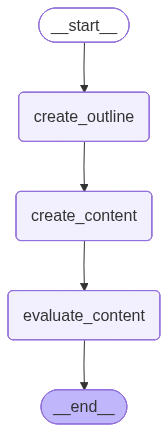

In [30]:
graph.compile()

In [31]:
workflow = graph.compile()

In [32]:
initial_state = {'title': "The Future of Art in Everyday Life"}
final_state = workflow.invoke(initial_state)

In [33]:
print(final_state)

{'title': 'The Future of Art in Everyday Life', 'outline': '**Outline: “The Future of Art in Everyday Life”**\n\n---\n\n### I. Introduction  \n1. **Why the topic matters** – art as a lens for cultural, social, and technological change.  \n2. **From “art for art’s sake” to “art for life’s sake”** – historical shift toward integration of art into daily routines.  \n3. **Thesis statement** – Emerging technologies, evolving social values, and new economic models will dissolve the boundary between art and everyday experience, making creativity a pervasive, participatory, and sustainable part of daily life.\n\n---\n\n### II. Technological Catalysts Transforming Everyday Art  \nA. **Artificial Intelligence & Generative Media**  \n   - AI‑driven image, music, and text generators (e.g., DALL‑E, ChatGPT, Stable Diffusion).  \n   - Personalised “creative assistants” for home décor, fashion, and storytelling.  \n\nB. **Extended Reality (XR) – AR & VR**  \n   - Overlaying digital artworks onto phys

In [34]:
print(final_state['evaluation'])

**Evaluation of “The Future of Art in Everyday Life – An Expanded Exploration of the Outline”**

Below is a structured assessment of the piece, focusing on **overall quality**, **coherence**, and **areas for improvement**. The feedback is organized by the major dimensions that matter for a scholarly‑oriented outline or a long‑form article.

---

## 1. Overall Quality

| Criterion | Rating (1‑5) | Comments |
|-----------|--------------|----------|
| **Depth of Content** | **5** | The outline covers a remarkably wide spectrum—technology, social impact, economics, ethics, and future scenarios. It goes well beyond a surface‑level survey. |
| **Breadth of Sources** | **4** | References to specific tools (DALL‑E, Stable Diffusion, ArtBlocks, etc.) and programs (Philadelphia Mural Arts, UNESCO Creative Cities) give the piece credibility. Adding a few academic citations (e.g., journal articles, conference papers) would raise the scholarly rigor. |
| **Originality** | **4** | The “art‑as‑life” 